In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import time as tm
import Sprayer_PDE as SP

import pypolo2

# Environment -- PINNS

In [2]:
# 初始化参数和环境污染浓度
Setting = pypolo2.utilities.Config()

In [3]:
# 确定存放地址
starttime = Setting.starttime.replace(' ', '-').replace(':', '-')
Savedir = '{}/{}/teamsize_{}'.format(Setting.root_dir,Setting.strategy_name,Setting.team_size)
Savename = 'seed{}'.format(Setting.seed)
Setting.save_dir = Savedir
Setting.save_name = Savename
evaluator = pypolo2.experiments.Evaluator()
logger = pypolo2.experiments.Logger(None, Setting)

# Sensor

In [4]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Pilot Survey

In [5]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 0 in random, numpy, and torch.


# Set initual data

In [6]:
# 初始化污染源
if Setting.randomsource == True:
    # gengerate two set of random numbers for source locations
    numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
    pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
    for i in range(Setting.sourcenum):
        number = rng.randint(40, 70, size=1)
        Setting.RR[i,0] = int(pairs[i,0])
        Setting.RR[i,1] = int(pairs[i,1])
        Setting.RR[i,2] = number

s = 1
Setting.R =  -3 * np.ones((Setting.grid_x, Setting.grid_y)) + 6 * np.random.random((Setting.grid_x, Setting.grid_y))
for i in range(Setting.sourcenum):
        Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model
Setting.env = env_model.solve(10)[-1]
sensor.set_env(Setting.env)

# 初始化高斯过程回归需要的参数
env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model

y_init = np.zeros((Setting.num_init_samples,1))
y_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))
time_init = np.zeros((Setting.num_init_samples,1))
time_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))

for time in range(Setting.time_before_sche):
    time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*1
    Setting.env = env_model.solve((time+1)*5)[-1]
    sensor.set_env(Setting.env)
    
#假设每次观测后均变化时间，环境也随之发生变化
for time in range(Setting.num_init_samples):
    y_init[time] = sensor.sense(states=Setting.x_init[time], rng=rng).reshape(-1, 1)
    if time == 0:
        y_stations[:] = y_init[time] - 20
    time_init[time] = (time+1)*1
    Setting.env = env_model.solve((1+Setting.time_before_sche+time)*5)[-1]
    sensor.set_env(Setting.env)
    
Setting.x_init = np.hstack((Setting.x_init,time_init))

Setting.x_stations = Setting.x_station
for i in range(Setting.time_before_sche-1):
    Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.hstack((Setting.x_stations,time_stations))

Setting.x_init = np.vstack((Setting.x_stations,Setting.x_init))
y_init = np.vstack((y_stations,y_init))

100%|██████████| 1.0/1.0 [00:00<00:00,  1.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  7.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  8.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  8.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.65it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  8.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.37it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.08it/s]    
100%|██████████| 1.0/1.0 [00

# Model

In [7]:
Setting.time_stamp = Setting.x_init[:,2].max(axis=0, keepdims=False)
kernel = pypolo2.kernels.RBF(Setting)
model = pypolo2.models.GPR(
    x_train=Setting.x_init,
    y_train=y_init,
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [8]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 05 loss:  8.64: 100%|██████████| 6/6 [00:00<00:00, 54.16it/s]


# Robot

In [9]:
vehicle_team = dict()
for i in range(Setting.team_size):
    robot = pypolo2.robots.SPRINKLER_REPLENISHANYWHERE(
        init_state = np.array([Setting.x_init[-1, 0], Setting.x_init[-1, 1]]),
        Setting = Setting
    )
    vehicle_team[i+1] = robot #因此team的id从1开始

# Strategy

In [10]:
strategy = pypolo2.strategies.SAEffectOrientedSelectiveSpray(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )
Setting.strategy = strategy

# Experiment

In [11]:
#定义需要随时间更新的训练过程
def run(rng, model, Setting, sensor, evaluator, logger, vehicle_team) -> None:
    current_step = 0 #总规划长度
    adaptive_step = Setting.adaptive_step #自适应长度
    change_step = 0
    spray_effect = 0 # 洒水效果
    result, MI_information, observed_env, computed_effect = None, None, None, None
    tstart = 0
    while current_step < Setting.max_num_samples:
        # 计算用于洒水效果,环境真实值已知
        allpoint_list = []
        env_list = []
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                allpoint_list.append([i, j, model.time_stamp])
                env_list.append(Setting.env[i,j])
        allpoint = np.array(allpoint_list)
        env = np.array(env_list)
        mean, _ = model(allpoint)
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, mean, Setting.task_extent).ravel()
        prior_diag_std, poste_diag_std, _, _ = model.prior_poste(allpoint)
        hprior = pypolo2.objectives.entropy.gaussian_entropy(prior_diag_std.ravel())
        hposterior = pypolo2.objectives.entropy.gaussian_entropy(poste_diag_std.ravel())
        mi_all = hprior - hposterior
        if np.any(mi_all < 0.0):
            print(mi_all.ravel())
            raise ValueError("Predictive MI < 0.0!")
        
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, env, Setting.task_extent).ravel()
        MI_information = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        observed_env = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        computed_effect = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                MI_information[i,j] = mi_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                observed_env[i,j] = Setting.env[i,j]
                computed_effect[i,j] = sprayeffect_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                
        Setting.current_step = current_step
        
        
        # scheduling and update agent goals ###################################################
        if adaptive_step >= Setting.adaptive_step:
            start = tm.time()
            result = Setting.strategy.get(model = model, Setting = Setting, pred = observed_env)
            adaptive_step = 0
            for id, vehicle in vehicle_team.items():
                vehicle.set_goals(result[id][0],result[id][1])
            end = tm.time()
            print('search_time')
            print(end-start)    
            
        # calculate metrix and save 
        coverage, mean_airpollution, max_airpollution = evaluator.eval_results(Setting.env, Setting.task_extent, vehicle_team)
        logger.append(current_step, Setting.env, observed_env, MI_information, computed_effect, vehicle_team, coverage, mean_airpollution, max_airpollution, spray_effect)
           
        # change source,每经过R_change_interval后，改变源分布和强度，
        if change_step >= Setting.R_change_interval:
            Setting.R =  -3 * np.ones((Setting.grid_x, Setting.grid_y)) + 6 * np.random.random((Setting.grid_x, Setting.grid_y))
            change_step = 0
            if Setting.randomsource == True:
                # gengerate two set of random numbers for source locations
                numbers = rng.randint(0, 4, size=Setting.sourcenum * 2)
                pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
                for i in range(Setting.sourcenum):
                    number = rng.randint(40, 70, size=1)
                    # number= 200
                    # Setting.RR[i,0] = int(pairs[i,0])
                    # Setting.RR[i,1] = int(pairs[i,1])
                    if Setting.RR[i,0]+pairs[i,0]-2 < Setting.grid_x-1 and Setting.RR[i,0] + pairs[i,0] - 2 >=0:
                        Setting.RR[i,0] = int(Setting.RR[i,0]+pairs[i,0]-2)
                    if Setting.RR[i,1]+pairs[i,1]-2 < Setting.grid_y-1 and Setting.RR[i,1] + pairs[i,1] - 2 >=0:
                        Setting.RR[i,1] = int(Setting.RR[i,1]+pairs[i,1]-2)
                    Setting.RR[i,2] = number
                tstart = current_step

        s = 1
        for i in range(Setting.sourcenum):
             Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
        # import sys
        # sys.exit()
        
        # 执行规划结果并推进仿真环境
        # 计算无洒水时的环境分布，推进表步长为1分钟
        env_model1 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                initial_field = Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = current_step * Setting.delta_t)
        env_withoutspray = env_model1.solve(Setting.delta_t)[-1]
            
        # update state 并将车辆的轨迹和洒水轨迹取出来
        x_new = []
        y_new = []
        for id, vehicle in vehicle_team.items():
            vehicle.update()
            current_state = vehicle.state.copy().reshape(1, -1)
            x_new.append(current_state)
            y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
            if Setting.current_step == 0:
                Setting.data_sprayer_train.append(pd.DataFrame())
            if vehicle.spray_flag == True:
                new_pd = pd.DataFrame({"time":(Setting.current_step + 1) * Setting.delta_t, "x":current_state[0,0],\
                                        "y":current_state[0,1], "spray_volume":200},index=[0])
                Setting.data_sprayer_train[id-1] = pd.concat([Setting.data_sprayer_train[id-1],new_pd])
            else:
                new_pd = pd.DataFrame({"time":(Setting.current_step + 1) * Setting.delta_t, "x":current_state[0,0],\
                                        "y":current_state[0,1], "spray_volume":0},index=[0])
                Setting.data_sprayer_train[id-1] = pd.concat([Setting.data_sprayer_train[id-1],new_pd])    
        # 计算带入洒水后的环境情况
        env_model2 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = current_step * Setting.delta_t) # build model
        env_withspray = env_model2.solve(Setting.delta_t)[-1]
        
        # 疑似污染源标记
        for id, vehicle in vehicle_team.items():
            current_state = vehicle.state.copy().reshape(1, -1).astype(int)
            # 如果当前状态在污染源四周，则认为已经发现了
            for i in range(Setting.sourcenum):
                # 判断是否在周围
                if ((current_state[0,0]-Setting.RR[i,0])**2 + (current_state[0,1]-Setting.RR[i,1])**2) <= 2:
                    # 判断是否已经发现
                    in_flag = False
                    for j in range(len(Setting.sources)):
                        if Setting.RR[i,0] == Setting.sources[j][0] and Setting.RR[i,1] == Setting.sources[j][1]:
                            in_flag = True
                    if in_flag:
                        continue
                    else:
                        Setting.sources.append([Setting.RR[i,0], Setting.RR[i,1]])         
                        
        print(Setting.sources)   
        Setting.env = env_withspray
        sensor.set_env(Setting.env)
        # 移除污染标记
        for i in range(len(Setting.sources)-1, -1, -1):
            if Setting.env[Setting.sources[i][0],Setting.sources[i][1]] <= 45:
                del Setting.sources[i]    
        
        # 计算洒水效果
        spray_effect = np.sum(env_withoutspray - Setting.env)
        print(spray_effect)
            
        # using new data to update gpr model
        x_new = np.concatenate(x_new, axis=0)
        y_new = np.concatenate(y_new, axis=0)
        #add time dim
        model.time_stamp = model.time_stamp + Setting.time_co
        Setting.time_stamp = model.time_stamp
        model_input = np.zeros((x_new.shape[0],3))
        model_input[:,0:2] = x_new
        model_input[:,2:3] = model.time_stamp
        #optimize model
        model.add_data(model_input, y_new)
        model.optimize(num_iter=len(y_new), verbose=False)
        
        adaptive_step = adaptive_step + 1     
        current_step = current_step + 1
        change_step = change_step + 1  
    return 0

In [12]:
start = tm.time()
Setting.strategy = strategy
run(rng, model, Setting, sensor, evaluator, logger, vehicle_team)
# pypolo2.experiments.utilities.print_metrics(logger, Setting.max_num_samples-1)
end = tm.time()
# logger.save(end-start)  # I temporarily removed "makefile()".

current_turn
1.0
agent_number
2
search_time
231.70948219299316


100%|██████████| 1.0/1.0 [00:00<00:00,  3.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  8.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.37it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.53it/s]    
100%|██████████| 1.0/1.0 [00

[]
0.0


100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.37it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  9.37it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00

[]
-4.319272179756137


100%|██████████| 1.0/1.0 [00:00<00:00,  2.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.26it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.05it/s]    
100%|██████████| 1.0/1.0 [00

[]
1.684735138952648
current_turn
2.0
search_time
31.534790992736816


100%|██████████| 1.0/1.0 [00:00<00:00,  2.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00

[]
-2.46449189516


100%|██████████| 1.0/1.0 [00:00<00:00,  2.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.44it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.08it/s]    
100%|██████████| 1.0/1.0 [00

[]
2.4034022670633854


100%|██████████| 1.0/1.0 [00:00<00:00,  2.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00

[[15, 3]]
1.562688013247909
current_turn
3.0
search_time
25.48994755744934


100%|██████████| 1.0/1.0 [00:00<00:00,  2.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00

[[15, 3]]
4040.0151048488547


100%|██████████| 1.0/1.0 [00:00<00:00,  1.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.13it/s]    
100%|██████████| 1.0/1.0 [00

[[15, 3]]
2561.9112683599296


100%|██████████| 1.0/1.0 [00:00<00:00,  2.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.23it/s]    
100%|██████████| 1.0/1.0 [00

[[15, 3], [12, 0]]
1462.609454488499
current_turn
4.0
search_time
30.95186972618103


100%|██████████| 1.0/1.0 [00:00<00:00,  1.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.01it/s]    
100%|██████████| 1.0/1.0 [00

[[15, 3], [12, 0]]
1052.5904363273773


100%|██████████| 1.0/1.0 [00:00<00:00,  2.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.38it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.44it/s]    
100%|██████████| 1.0/1.0 [00

[[15, 3], [12, 0]]
938.5898407346394


100%|██████████| 1.0/1.0 [00:00<00:00,  2.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.60it/s]    
100%|██████████| 1.0/1.0 [00

[[15, 3], [12, 0]]
448.43383436830726
current_turn
5.0
search_time
27.49973225593567


100%|██████████| 1.0/1.0 [00:00<00:00,  2.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00

[[15, 3], [12, 0], [13, 2]]
1.082099340876038


100%|██████████| 1.0/1.0 [00:00<00:00,  2.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.33it/s]    
100%|██████████| 1.0/1.0 [00

[[15, 3], [12, 0], [13, 2]]
-1.582894737019961


100%|██████████| 1.0/1.0 [00:00<00:00,  1.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.81it/s]    
100%|██████████| 1.0/1.0 [00

[[15, 3], [12, 0], [13, 2], [10, 0]]
1727.1197057761333
current_turn
6.0
search_time
28.122101306915283


100%|██████████| 1.0/1.0 [00:00<00:00,  2.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.68it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.35it/s]    
100%|██████████| 1.0/1.0 [00

[[15, 3], [12, 0], [13, 2], [10, 0]]
1521.5426415510683


100%|██████████| 1.0/1.0 [00:00<00:00,  1.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.05it/s]    
100%|██████████| 1.0/1.0 [00

[[12, 0], [13, 2], [10, 0]]
1210.666231964367


100%|██████████| 1.0/1.0 [00:00<00:00,  2.37it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.85it/s]    
100%|██████████| 1.0/1.0 [00

[[13, 2], [10, 0]]
1080.283011229319
current_turn
7.0
search_time
27.72453761100769


100%|██████████| 1.0/1.0 [00:00<00:00,  2.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.65it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.37it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.38it/s]    
100%|██████████| 1.0/1.0 [00

[[13, 2], [10, 0]]
689.8933632179261


100%|██████████| 1.0/1.0 [00:00<00:00,  1.88it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00

[[13, 2], [10, 0], [12, 2]]
0.0


100%|██████████| 1.0/1.0 [00:00<00:00,  2.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.94it/s]    
100%|██████████| 1.0/1.0 [00

[[13, 2], [10, 0], [12, 2]]
1008.4990168817727
current_turn
8.0
search_time
29.29704976081848


100%|██████████| 1.0/1.0 [00:00<00:00,  2.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.65it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00

[[13, 2], [10, 0], [12, 2]]
737.6029159627396


100%|██████████| 1.0/1.0 [00:00<00:00,  2.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.10it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00

[[13, 2], [10, 0], [12, 2]]
1560.7086759194744


100%|██████████| 1.0/1.0 [00:00<00:00,  2.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00

[[13, 2], [10, 0], [12, 2], [8, 0]]
1486.2114406602664
current_turn
9.0
search_time
23.990774869918823


100%|██████████| 1.0/1.0 [00:00<00:00,  2.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.88it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.45it/s]    
100%|██████████| 1.0/1.0 [00

[[13, 2], [10, 0], [12, 2], [8, 0]]
1073.5740048349317


100%|██████████| 1.0/1.0 [00:00<00:00,  2.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.58it/s]    
100%|██████████| 1.0/1.0 [00

[[13, 2], [10, 0], [12, 2], [8, 0]]
1239.9368736168408


100%|██████████| 1.0/1.0 [00:00<00:00,  2.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.85it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0]]
981.2363271437077
current_turn
10.0
search_time
29.338690757751465


100%|██████████| 1.0/1.0 [00:00<00:00,  2.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.08it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0]]
240.44298819111552


100%|██████████| 1.0/1.0 [00:00<00:00,  2.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.65it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.79it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0]]
325.89187777582805


100%|██████████| 1.0/1.0 [00:00<00:00,  2.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.44it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0]]
489.499791827677
current_turn
11.0
search_time
25.93761396408081


100%|██████████| 1.0/1.0 [00:00<00:00,  2.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.08it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [8, 1], [9, 0]]
2272.317751489134


100%|██████████| 1.0/1.0 [00:00<00:00,  2.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.17it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [8, 1], [9, 0]]
1612.1168205048693


100%|██████████| 1.0/1.0 [00:00<00:00,  2.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.10it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.07it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [8, 1], [9, 0]]
1357.9609476029107
current_turn
12.0
search_time
21.021746158599854


100%|██████████| 1.0/1.0 [00:00<00:00,  2.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.20it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [8, 1], [9, 0]]
1244.055293830791


100%|██████████| 1.0/1.0 [00:00<00:00,  2.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.44it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.74it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.03it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [8, 1], [9, 0]]
735.6261831284189


100%|██████████| 1.0/1.0 [00:00<00:00,  2.37it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.81it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.24it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [8, 1], [9, 0]]
-4.550368481428888
current_turn
13.0
search_time
13.72403073310852


100%|██████████| 1.0/1.0 [00:00<00:00,  2.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.38it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [8, 1], [9, 0]]
404.57893092217125


100%|██████████| 1.0/1.0 [00:01<00:00,  1.06s/it]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.65it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.31it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [8, 1], [9, 0]]
958.4242101643772


100%|██████████| 1.0/1.0 [00:00<00:00,  2.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.66it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [8, 1], [9, 0]]
2230.305969949072
current_turn
14.0
search_time
8.129408359527588


100%|██████████| 1.0/1.0 [00:00<00:00,  2.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.65it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.30it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [8, 1], [9, 0], [7, 0]]
1554.3209932539141


100%|██████████| 1.0/1.0 [00:00<00:00,  2.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.05it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [9, 0], [7, 0]]
1095.3125616925993


100%|██████████| 1.0/1.0 [00:00<00:00,  1.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.17it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [9, 0], [7, 0]]
908.0446764842627
current_turn
15.0
search_time
6.397512912750244


100%|██████████| 1.0/1.0 [00:00<00:00,  2.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [9, 0], [7, 0], [7, 1]]
441.70334362791823


100%|██████████| 1.0/1.0 [00:00<00:00,  2.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.59it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [9, 0], [7, 0], [7, 1]]
0.0


100%|██████████| 1.0/1.0 [00:00<00:00,  2.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.38it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.55it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 0], [8, 0], [9, 0], [7, 0], [7, 1]]
435.3846147232501
current_turn
16.0
search_time
7.097275257110596


100%|██████████| 1.0/1.0 [00:00<00:00,  2.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.06it/s]    
100%|██████████| 1.0/1.0 [00

[[8, 0], [9, 0], [7, 0], [7, 1]]
624.6554482148194


100%|██████████| 1.0/1.0 [00:00<00:00,  1.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.38it/s]    
100%|██████████| 1.0/1.0 [00

[[8, 0], [7, 0], [7, 1]]
870.8791287460753


100%|██████████| 1.0/1.0 [00:00<00:00,  2.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.68it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.56it/s]    
100%|██████████| 1.0/1.0 [00

[[7, 0], [7, 1]]
762.199570483911


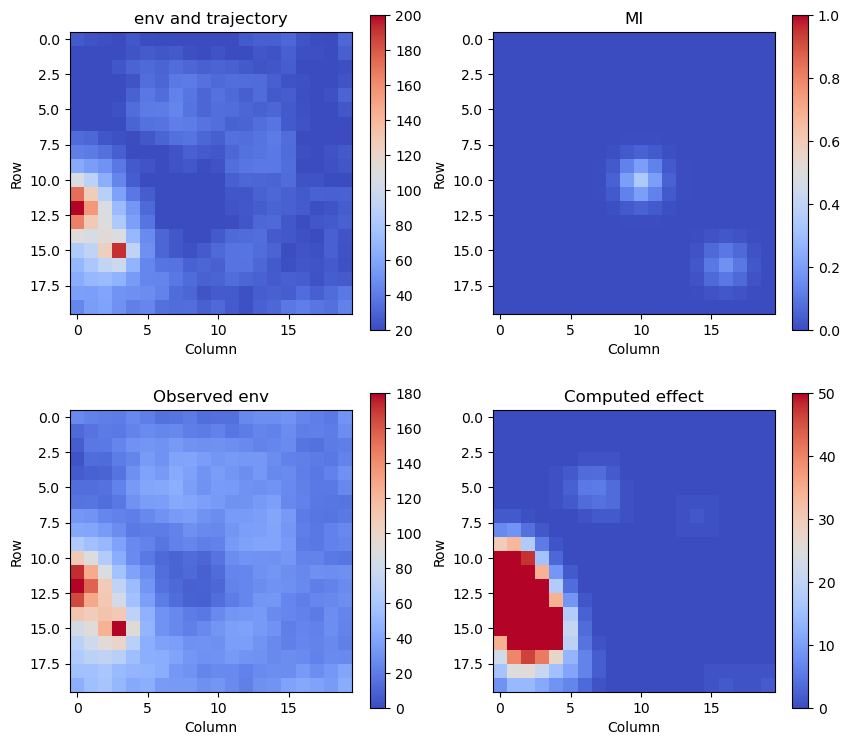

In [13]:
from pypolo2.experiments import visualizer
ani = visualizer.visual(logger)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

In [14]:
import math
import numpy as np
Temp = 25
k = math.pow(0.75, 1 / 400)
k = math.pow(k, 100)
print(k * Temp)
delta_e_2 = -20
accept_prob = np.exp(delta_e_2 / (k * Temp))
print(k)
print(accept_prob)

23.26512147755254
0.9306048591021017
0.4233076982022872


In [15]:
Setting.RR

array([[ 7,  1, 43],
       [ 7,  1, 63]])